In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math

%matplotlib inline

In [3]:
df = pd.read_csv('winequality-white.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


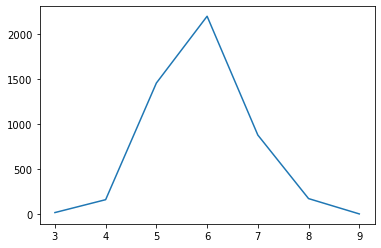

In [4]:
count_element = df.groupby('quality')['quality'].count()
plt.plot(count_element)

In [5]:
y = df['quality'].values
newlabel = []

for val in y:
    if val <= 3:
        newlabel.append(0)
    elif val <= 7:
        newlabel.append(1)
    else:
        newlabel.append(2)

In [6]:
import collections

a = collections.Counter(newlabel)
list_a = []
for i in range(len(a)):
    list_a.append(a[i])

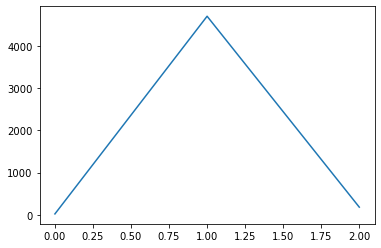

In [7]:
plt.plot(list_a)

In [8]:
class Model(nn.Module):
    def __init__(self, in_features=11, h1=8, h2=9, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x

In [9]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
class WineDataset(Dataset):
    def __init__(self):
        df = pd.read_csv('winequality-white.csv', sep=';')
        y = df['quality'].values
        newlabel = []

        for val in y:
            if val <= 3:
                newlabel.append(0)
            elif val <= 7:
                newlabel.append(1)
            else:
                newlabel.append(2)

        X = df.drop('quality', axis=1).values
        y = newlabel

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        self.x_data = torch.FloatTensor(X_train)
        self.x_test = torch.FloatTensor(X_test)
        self.y_data = torch.LongTensor(y_train)
        self.y_test = torch.LongTensor(y_test)

        self.num = len(self.y_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.num

In [12]:
epochs = 50
Batch_size = 500
loss_list = []

dataset = WineDataset()
trainloader = DataLoader(dataset=dataset, batch_size=Batch_size, shuffle=True)

In [13]:
total_samples = len(dataset)
print(total_samples)
n_iterations = math.ceil(total_samples/Batch_size)
print(n_iterations)

3918
8


In [15]:
for epoch in range(epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        print(f'Epoch: {epoch+1}/{epochs} Iteration {i+1}/{n_iterations} Inputs {inputs.shape} Labels {labels.shape}')
        y_pred = model.forward(inputs.data)
        loss = criterion(y_pred, labels.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.detach())

Epoch: 1/50 Iteration 1/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 1/50 Iteration 2/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 1/50 Iteration 3/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 1/50 Iteration 4/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 1/50 Iteration 5/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 1/50 Iteration 6/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 1/50 Iteration 7/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 1/50 Iteration 8/8 Inputs torch.Size([418, 11]) Labels torch.Size([418])
Epoch: 2/50 Iteration 1/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 2/50 Iteration 2/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 2/50 Iteration 3/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 2/50 Iteration 4/8 Inputs torch.Size([500, 11]) Labels torch.Size([500])
Epoch: 2/50 Iteration 5/8 Inputs torch.S

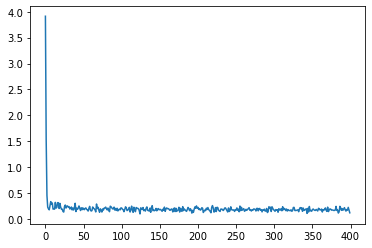

In [16]:
plt.plot(loss_list)

In [17]:
with torch.no_grad():
    predicted_y = model.forward(dataset.x_test)
    loss = criterion(predicted_y, dataset.y_test)

print(loss.item())

0.17145566642284393


In [19]:
correct = 0
with torch.no_grad():
    for i, data in enumerate(dataset.x_test):
        y_val = model.forward(data)
        if y_val.argmax().item() == dataset.y_test[i]:
            correct += 1

print(f'{correct} out of {len(dataset.y_test)} = {round(100*correct/len(dataset.y_test),2)}%')

944 out of 980 = 96.33%
